In [122]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pesummary.gw.conversions.mass import component_masses_from_mchirp_q, q_from_eta
from pycbc import psd as psd_func
from pycbc.filter import sigma, match
from simple_pe.waveforms import make_waveform, calc_f_gen, two_ecc_harms_SNR, calculate_mode_snr, generate_eccentric_waveform_MA
from calcwf import match_hn

# Disable pesummary warnings
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

# Otherwise plt.savefig crashes with latex errors
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# e=0.2, chirp=24

In [143]:
# Data settings
true_dict = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
target_snr = 20
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': data.to_timeseries()*target_snr/raw_snr}
true_dict['distance'] = raw_snr/target_snr

## Performing direct match to data

### Exact degeneracy line

In [144]:
# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_0/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

# Shift degeneracy line to pass through true point
mult = true_dict['ecc10sqrd']/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
for key in ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    proj_point = mult*(fid_dict[key]-base_dict[key])+base_dict[key]
    proj_diff = true_dict[key]-proj_point
    base_dict[key] += proj_diff
    fid_dict[key] += proj_diff

In [148]:
# Loop over distance along degeneracy line
data_ecc_SNRs_ = []
trial_ecc_SNRs_ = []
data_matches_ = []
param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
e10s_ = np.linspace(0, 0.5, 21)
for i, e10 in enumerate(e10s_):
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Make eccentric harmonics and match to data
    ecc_harms = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
    wf_hjs = [ecc_harms[k].to_timeseries() for k in [0, 1, -1, 2]]
    f_gen = calc_f_gen(f_low, 4)
    match_cplx = match_hn(wf_hjs, data['H1'], f_gen, psd=psd['H1'], f_match=f_low)
    # data_ecc_SNR = np.abs(match_cplx[1])/np.abs(match_cplx[0])
    # target_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0])) % (2*np.pi)
    data_ecc_SNR, target_MA = two_ecc_harms_SNR({0: np.abs(match_cplx[0]), 1: np.abs(match_cplx[1]), -1: np.abs(match_cplx[2])},
                                                {0: np.angle(match_cplx[0]), 1: np.angle(match_cplx[1]), -1: np.angle(match_cplx[2])})
    data_ecc_SNR = data_ecc_SNR*np.exp(1j*target_MA)
    data_ecc_SNRs_.append(np.abs(data_ecc_SNR))
    
    # Calculate trial waveform with correct MA and match to data
    two_ecc_harms=True
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd['H1'], f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)
    data_match, _ = match(data['H1'], trial_wf, psd=psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
    data_matches_.append(data_match)

    # Match trial waveform to eccentric harmonics
    trial_z, _ = calculate_mode_snr(trial_wf, psd['H1'], ecc_harms, trial_wf.sample_times[0],
                                    trial_wf.sample_times[-1], f_low, ecc_harms.keys(),
                                    dominant_mode=0)
    if two_ecc_harms:
        harm_ids = [0, 1, -1]
        ecc_SNR_abs, ecc_SNR_ang = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in harm_ids},
            {k: np.angle(trial_z[k]) for k in harm_ids})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
        ecc_SNR_ang = (np.angle(trial_z[1])-np.angle(trial_z[0])) % (2*np.pi)
    trial_ecc_SNR = ecc_SNR_abs*np.exp(1j*ecc_SNR_ang)
    trial_ecc_SNRs_.append(np.abs(trial_ecc_SNR))

    print(f'\r{i+1} complete out of {len(e10s)}', end='')

21 complete out of 21

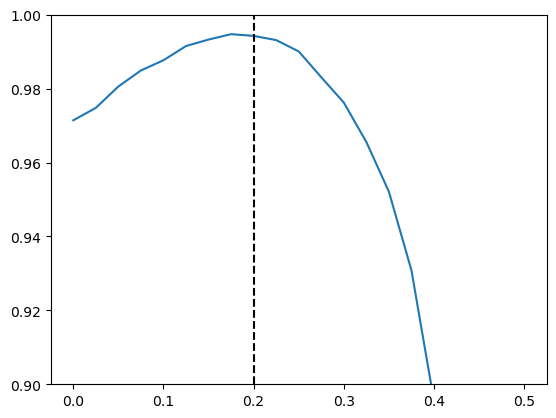

In [149]:
# Plot results
plt.plot(e10s_, data_matches_)
plt.ylim(0.9,1)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.show()

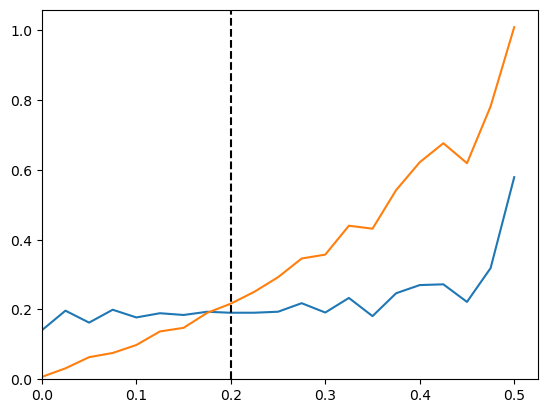

In [150]:
# Plot results
plt.plot(e10s_, data_ecc_SNRs_)
plt.plot(e10s_, trial_ecc_SNRs_)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.ylim(0,)
plt.xlim(0,)
plt.show()

### Imperfect degeneracy line

In [59]:
# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_0/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

In [64]:
# Loop over distance along degeneracy line
data_ecc_SNRs__ = []
trial_ecc_SNRs__ = []
data_matches__ = []
param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
e10s__ = np.linspace(0.05, 0.25, 21)
for i, e10 in enumerate(e10s__):
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Make eccentric harmonics and match to data
    ecc_harms = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
    wf_hjs = [ecc_harms[k].to_timeseries() for k in [0, 1, -1, 2]]
    f_gen = calc_f_gen(f_low, 4)
    match_cplx = match_hn(wf_hjs, data['H1'], f_gen, psd=psd['H1'], f_match=f_low)
    # data_ecc_SNR = np.abs(match_cplx[1])/np.abs(match_cplx[0])
    # target_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0])) % (2*np.pi)
    data_ecc_SNR, target_MA = two_ecc_harms_SNR({0: np.abs(match_cplx[0]), 1: np.abs(match_cplx[1]), -1: np.abs(match_cplx[2])},
                                                {0: np.angle(match_cplx[0]), 1: np.angle(match_cplx[1]), -1: np.angle(match_cplx[2])})
    data_ecc_SNR = data_ecc_SNR*np.exp(1j*target_MA)
    data_ecc_SNRs__.append(np.abs(data_ecc_SNR))
    
    # Calculate trial waveform with correct MA and match to data
    two_ecc_harms=True
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd['H1'], f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)
    data_match, _ = match(data['H1'], trial_wf, psd=psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
    data_matches__.append(data_match)

    # Match trial waveform to eccentric harmonics
    trial_z, _ = calculate_mode_snr(trial_wf, psd['H1'], ecc_harms, trial_wf.sample_times[0],
                                    trial_wf.sample_times[-1], f_low, ecc_harms.keys(),
                                    dominant_mode=0)
    if two_ecc_harms:
        harm_ids = [0, 1, -1]
        ecc_SNR_abs, ecc_SNR_ang = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in harm_ids},
            {k: np.angle(trial_z[k]) for k in harm_ids})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
        ecc_SNR_ang = (np.angle(trial_z[1])-np.angle(trial_z[0])) % (2*np.pi)
    trial_ecc_SNR = ecc_SNR_abs*np.exp(1j*ecc_SNR_ang)
    trial_ecc_SNRs__.append(np.abs(trial_ecc_SNR))

    print(f'\r{i+1} complete out of {len(e10s)}', end='')

21 complete out of 21

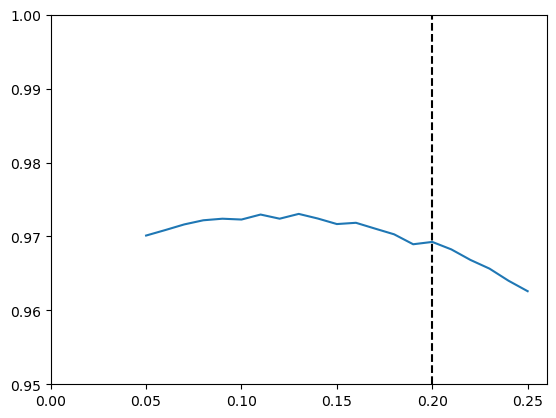

In [68]:
# Plot results
plt.plot(e10s__, data_matches__)
plt.ylim(0.95,1)
plt.xlim(0,)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.show()

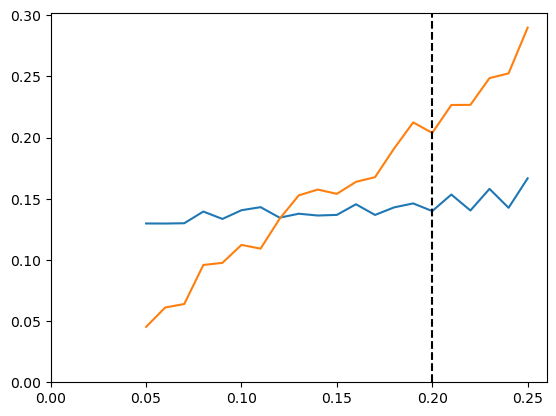

In [70]:
# Plot results
plt.plot(e10s__, data_ecc_SNRs__)
plt.plot(e10s__, trial_ecc_SNRs__)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.ylim(0,)
plt.xlim(0,)
plt.show()

# e=0.3, chirp=16

In [71]:
# Data settings
true_dict = {'ecc10sqrd': 0.3**2, 'chirp_mass': 16, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
target_snr = 20
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': data.to_timeseries()*target_snr/raw_snr}
true_dict['distance'] = raw_snr/target_snr

## Performing direct match to data

### Exact degeneracy line

In [72]:
# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_1/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

# Shift degeneracy line to pass through true point
mult = true_dict['ecc10sqrd']/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
for key in ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    proj_point = mult*(fid_dict[key]-base_dict[key])+base_dict[key]
    proj_diff = true_dict[key]-proj_point
    base_dict[key] += proj_diff
    fid_dict[key] += proj_diff

In [73]:
# Loop over distance along degeneracy line
data_ecc_SNRs_ = []
trial_ecc_SNRs_ = []
data_matches_ = []
param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
e10s = np.linspace(0, 0.5, 21)
for i, e10 in enumerate(e10s):
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Make eccentric harmonics and match to data
    ecc_harms = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
    wf_hjs = [ecc_harms[k].to_timeseries() for k in [0, 1, -1, 2]]
    f_gen = calc_f_gen(f_low, 4)
    match_cplx = match_hn(wf_hjs, data['H1'], f_gen, psd=psd['H1'], f_match=f_low)
    # data_ecc_SNR = np.abs(match_cplx[1])/np.abs(match_cplx[0])
    # target_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0])) % (2*np.pi)
    data_ecc_SNR, target_MA = two_ecc_harms_SNR({0: np.abs(match_cplx[0]), 1: np.abs(match_cplx[1]), -1: np.abs(match_cplx[2])},
                                                {0: np.angle(match_cplx[0]), 1: np.angle(match_cplx[1]), -1: np.angle(match_cplx[2])})
    data_ecc_SNR = data_ecc_SNR*np.exp(1j*target_MA)
    data_ecc_SNRs_.append(np.abs(data_ecc_SNR))
    
    # Calculate trial waveform with correct MA and match to data
    two_ecc_harms=True
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd['H1'], f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)
    data_match, _ = match(data['H1'], trial_wf, psd=psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
    data_matches_.append(data_match)

    # Match trial waveform to eccentric harmonics
    trial_z, _ = calculate_mode_snr(trial_wf, psd['H1'], ecc_harms, trial_wf.sample_times[0],
                                    trial_wf.sample_times[-1], f_low, ecc_harms.keys(),
                                    dominant_mode=0)
    if two_ecc_harms:
        harm_ids = [0, 1, -1]
        ecc_SNR_abs, ecc_SNR_ang = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in harm_ids},
            {k: np.angle(trial_z[k]) for k in harm_ids})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
        ecc_SNR_ang = (np.angle(trial_z[1])-np.angle(trial_z[0])) % (2*np.pi)
    trial_ecc_SNR = ecc_SNR_abs*np.exp(1j*ecc_SNR_ang)
    trial_ecc_SNRs_.append(np.abs(trial_ecc_SNR))

    print(f'\r{i+1} complete out of {len(e10s)}', end='')

21 complete out of 21

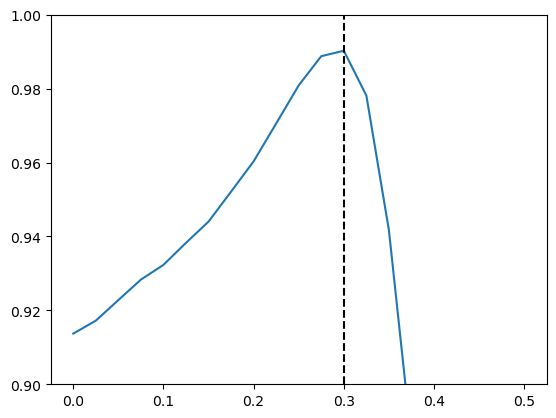

In [74]:
# Plot results
plt.plot(e10s, data_matches_)
plt.ylim(0.9,1)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.show()

### Imperfect degeneracy line

In [75]:
# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_1/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

In [84]:
# Loop over distance along degeneracy line
data_ecc_SNRs__ = []
trial_ecc_SNRs__ = []
data_matches__ = []
param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
e10s__ = np.linspace(0.2, 0.4, 21)
for i, e10 in enumerate(e10s__):
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Make eccentric harmonics and match to data
    ecc_harms = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
    wf_hjs = [ecc_harms[k].to_timeseries() for k in [0, 1, -1, 2]]
    f_gen = calc_f_gen(f_low, 4)
    match_cplx = match_hn(wf_hjs, data['H1'], f_gen, psd=psd['H1'], f_match=f_low)
    # data_ecc_SNR = np.abs(match_cplx[1])/np.abs(match_cplx[0])
    # target_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0])) % (2*np.pi)
    data_ecc_SNR, target_MA = two_ecc_harms_SNR({0: np.abs(match_cplx[0]), 1: np.abs(match_cplx[1]), -1: np.abs(match_cplx[2])},
                                                {0: np.angle(match_cplx[0]), 1: np.angle(match_cplx[1]), -1: np.angle(match_cplx[2])})
    data_ecc_SNR = data_ecc_SNR*np.exp(1j*target_MA)
    data_ecc_SNRs__.append(np.abs(data_ecc_SNR))
    
    # Calculate trial waveform with correct MA and match to data
    two_ecc_harms=True
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd['H1'], f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)
    data_match, _ = match(data['H1'], trial_wf, psd=psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
    data_matches__.append(data_match)

    # Match trial waveform to eccentric harmonics
    trial_z, _ = calculate_mode_snr(trial_wf, psd['H1'], ecc_harms, trial_wf.sample_times[0],
                                    trial_wf.sample_times[-1], f_low, ecc_harms.keys(),
                                    dominant_mode=0)
    if two_ecc_harms:
        harm_ids = [0, 1, -1]
        ecc_SNR_abs, ecc_SNR_ang = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in harm_ids},
            {k: np.angle(trial_z[k]) for k in harm_ids})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
        ecc_SNR_ang = (np.angle(trial_z[1])-np.angle(trial_z[0])) % (2*np.pi)
    trial_ecc_SNR = ecc_SNR_abs*np.exp(1j*ecc_SNR_ang)
    trial_ecc_SNRs__.append(np.abs(trial_ecc_SNR))

    print(f'\r{i+1} complete out of {len(e10s)}', end='')

21 complete out of 21

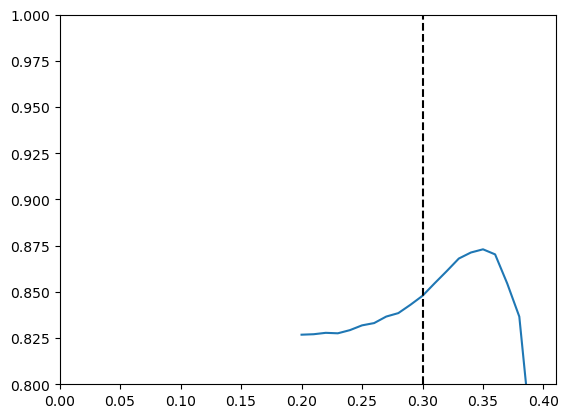

In [85]:
# Plot results
plt.plot(e10s__, data_matches__)
plt.ylim(0.8,1)
plt.xlim(0,)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.show()

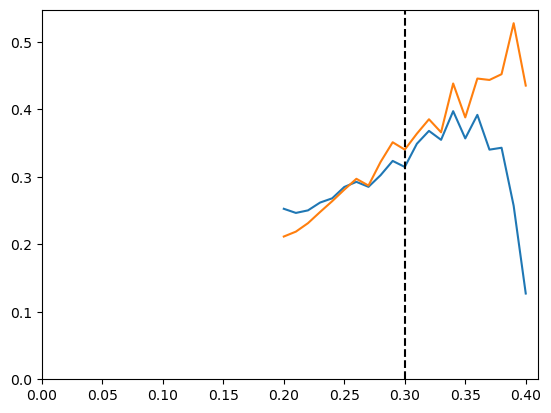

In [86]:
# Plot results
plt.plot(e10s__, data_ecc_SNRs__)
plt.plot(e10s__, trial_ecc_SNRs__)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.ylim(0,)
plt.xlim(0,)
plt.show()

# Method

In [152]:
def gen_test_wfs(data, params, f_low, psd, n_ecc_harms, two_ecc_harms=True, return_all=False):
    print(params['ecc10sqrd']**0.5)

    # Make eccentric harmonics
    ecc_harms = make_waveform(params, psd.delta_f, f_low, len(psd), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=n_ecc_harms)
    wf_hjs = [ecc_harms[k].to_timeseries() for k in [0, 1, -1, 2]] # Need to change to account for n_ecc_harms
    f_gen = calc_f_gen(f_low, n_ecc_harms)

    # Match harmonics to data
    match_cplx = match_hn(wf_hjs, data, f_gen, psd=psd, f_match=f_low)
    if two_ecc_harms:
        data_ecc_SNR, target_MA = two_ecc_harms_SNR({0: np.abs(match_cplx[0]), 1: np.abs(match_cplx[1]), -1: np.abs(match_cplx[2])},
                                                    {0: np.angle(match_cplx[0]), 1: np.angle(match_cplx[1]), -1: np.angle(match_cplx[2])})
    else:
        data_ecc_SNR = np.abs(match_cplx[1])/np.abs(match_cplx[0])
        target_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0])) % (2*np.pi)

    # Make trial waveform at correct MA and match to data
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd, f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)

    if return_all:
        return trial_wf, ecc_harms, data_ecc_SNR
    return trial_wf

In [135]:
def test_ecc_point(e10, data, base_dict, fid_dict, f_low, psd, n_ecc_harms, two_ecc_harms=True):
    
    # Make param dictionary
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Create harmonics and trial waveform
    gen_test_wfs(data, params, f_low, psd, n_ecc_harms, two_ecc_harms=True)
    trial_wf = gen_test_wfs(data, params, f_low, psd, n_ecc_harms, two_ecc_harms=True)
    data_match, _ = match(data, trial_wf, psd=psd, low_frequency_cutoff=f_low, high_frequency_cutoff=psd.sample_frequencies[-1])

    return -data_match

In [147]:
def find_ecc_peak(data, base_dict, fid_dict, f_low, psd, n_ecc_harms, two_ecc_harms=True):

    # Find initial guess
    first_trial_wf, first_ecc_harms, first_data_ecc_SNR = gen_test_wfs(data, fid_dict.copy(), f_low, psd, n_ecc_harms,
                                                                       two_ecc_harms=True, return_all=True)
    trial_z, _ = calculate_mode_snr(first_trial_wf, psd, first_ecc_harms, first_trial_wf.sample_times[0],
                                    first_trial_wf.sample_times[-1], f_low, first_ecc_harms.keys(),
                                    dominant_mode=0)
    if two_ecc_harms:
        ecc_SNR_abs, _ = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in [0, 1, -1]},
            {k: np.angle(trial_z[k]) for k in [0, 1, -1]})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
    init_e10 = (first_data_ecc_SNR/ecc_SNR_abs)*(fid_dict['ecc10sqrd']**0.5)
    print(ecc_SNR_abs, first_data_ecc_SNR, fid_dict['ecc10sqrd']**0.5)
    print(init_e10)
    print('')
    init_e10 = 0.2

    # Use scipy optimise to find maximum match
    bounds = [(0, 0.8)]
    peak_e10 = minimize(lambda x: test_ecc_point(x, data, base_dict, fid_dict, f_low, psd, n_ecc_harms, two_ecc_harms=two_ecc_harms),
                        init_e10, bounds=bounds, method='Nelder-Mead')

    return peak_e10

In [141]:
# Data settings
true_dict = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
target_snr = 20
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': data.to_timeseries()*target_snr/raw_snr}
true_dict['distance'] = raw_snr/target_snr

# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_0/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

# Shift degeneracy line to pass through true point
mult = true_dict['ecc10sqrd']/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
for key in ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    proj_point = mult*(fid_dict[key]-base_dict[key])+base_dict[key]
    proj_diff = true_dict[key]-proj_point
    base_dict[key] += proj_diff
    fid_dict[key] += proj_diff

start = time.time()
peak_e_10 = find_ecc_peak(data['H1'], base_dict, fid_dict, f_low, psd['H1'], 4)
print(peak_e_10)
end = time.time()
print(f'{end-start} seconds')

[0.1041551]
0.24467945943583733 0.25427748670949757 [0.1041551]
[0.10022363]

[0.2]
[0.2]
[0.21]
[0.21]
[0.19]
[0.19]
[0.18]
[0.18]
[0.16]
[0.16]
[0.17]
[0.17]
[0.19]
[0.19]
[0.185]
[0.185]
[0.175]
[0.175]
[0.185]
[0.185]
[0.1775]
[0.1775]
[0.175]
[0.175]
[0.17875]
[0.17875]
[0.17875]
[0.17875]
[0.17625]
[0.17625]
[0.178125]
[0.178125]
[0.178125]
[0.178125]
[0.176875]
[0.176875]
[0.1771875]
[0.1771875]
[0.1778125]
[0.1778125]
[0.1771875]
[0.1771875]
[0.17734375]
[0.17734375]
[0.17765625]
[0.17765625]
[0.17734375]
[0.17734375]
[0.17742188]
[0.17742188]
[0.17757813]
[0.17757813]
[0.17742188]
[0.17742188]
[0.17753906]
[0.17753906]



KeyboardInterrupt

